<a href="https://colab.research.google.com/github/alongstar518/cs221_finalproject/blob/master/cs221_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS221 Final Project: Steel Defect Detection 


### install packages

In [0]:
# No

### Import necessary libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import pdb

import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torch.utils.model_zoo as model_zoo
from torchvision import transforms
import torch.nn.functional as F
import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

### Print torch and cuda information

In [0]:
print("torch version: {}".format(torch.__version__))
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
print("Cuda device name: {}".format(torch.cuda.get_device_name()))
print("Cuda device Capilibility: {}".format(
    torch.cuda.get_device_capability(device=None)
  )
)
gpu_ram = (
    torch.cuda.get_device_properties(device=None).total_memory / (1024) **3
)
print(f"GPU RAM: {gpu_ram} GB")
#!nvidia-smi

torch version: 1.3.1+cu100
Cuda device avaliablity: True
Cuda device name: Tesla P100-PCIE-16GB
Cuda device Capilibility: (6, 0)
GPU RAM: 15.8992919921875 GB


# configs


##basic config:

In [0]:
reload_data = True
clear_tensor_board_history = True
reload_last_model = True
leave_progress_bar = False
inference_mode = False
debug = False

# path to local project folder contains the data
path = "/home/user/git/cs221_finalproject"
data_path = os.path.join(path, "data")


## data split set

In [0]:
train_data_percent = 0.8
eval_data_percent = 0.1
test_data_percent = 0.1 

##hyperparamters:

In [0]:
batch_size = 16
n_classes = 5
total_epochs = 100
weight_decay=1e-4
lr = 0.01
momentum=0.9
eval_interval = 200

#Data

### download data

In [0]:
try:
  # delay import so we can run on local machine
  # this also check if run it on google drive or not . if it is not, it will 
  # avoiding runing from google colab, but running from local.
  from google.colab import drive
  path = "/content/drive/My Drive/share/"
  remote_data_path = os.path.join(path, "data")
  data_path = "/content/data"
  data_zip_path = os.path.join(
        remote_data_path, "severstal-steel-defect-detection.zip"
      )
  model_save_path = path
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  res18_path = os.path.join(remote_data_path, "resnet18")
  os.makedirs(data_path, exist_ok=True)
  res18_path_dst = os.path.join(data_path, "resnet18")
  # you may find res18 folder here:
  # "https://drive.google.com/drive/folders/
  #  1KFKRraGbNUICgkgSabzrfHeJzYc5YE0W?usp=sharing"

  if reload_data:
    print("login to google drive")
    drive.mount('/content/drive')
    print("Copy raw data from {} to {}".format(
        data_zip_path, data_zip_path_dst)
    )
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, data_path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"train_images.zip"), 
        os.path.join(data_path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"test_images.zip"), 
        os.path.join(data_path,"test_images")
      )
    )
    !ls /content/data
except Exception as e:
  print(e)
  print("Running on local machine.")
finally:
  model_save_path = os.path.join(path, "best.pth")


login to google drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Copy raw data from /content/drive/My Drive/share/data/severstal-steel-defect-detection.zip to /content/severstal-steel-defect-detection.zip
unzip raw data...
give back missing permissions for unzipping
unzipping data...
sample_submission.csv  test_images.zip	train_images
test_images	       train.csv	train_images.zip


In [0]:
tr = pd.read_csv(os.path.join(data_path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [0]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
if debug:
  df_train = df_train[:100]
#df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


### data preprocessing function

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )


def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Display some sample images

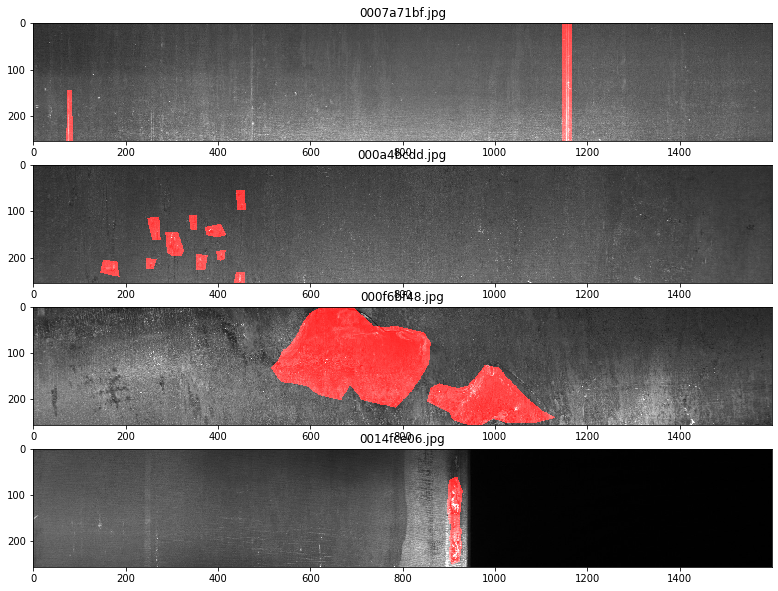

In [0]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread(data_path + '/train_images/'+fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset argumentation and DataLoader

In [0]:
label_color = np.asarray([
                          [0, 0, 0],  #background
                          [128, 0, 0], 
                          [0, 128, 0],
                          [128, 128, 0],
                          [0, 0, 128]
                        ])

def encode_segmap(mask, category):
    label_mask = np.zeros((mask.shape[1], mask.shape[2]), dtype=np.int16)
    label_mask[np.where(np.all(mask > 0, axis=-1))[1:]] = category
    return label_mask

class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = data_path + '/train_images/'
        elif self.subset == "test":
            self.data_path = data_path + '/test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn_array = self.df['ImageId_ClassId'].iloc[index].split('_')
        fn = fn_array[0]
        category = fn_array[1] 
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train':
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)
            mask = self.transform(mask)
            mask = mask.numpy()
            mask[mask > 0] = int(category)
            mask = torch.from_numpy(mask)
            return img, mask
        else:
            mask = None
        return img  

In [0]:
data_transf = transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.ToTensor()
    ]
)

train_indx = int(len(df_train) * train_data_percent)
df_tr = df_train[0: train_indx]

eval_indx = int(len(df_train) * eval_data_percent) + train_indx
df_eval = df_train[train_indx: eval_indx]

df_test = df_train[eval_indx:]

train_data = ImageData(df = df_tr, transform = data_transf)
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True,
  )

eval_data = ImageData(df = df_eval, transform = data_transf)
eval_loader = DataLoader(dataset = eval_data)

test_data = ImageData(df = df_test, transform = data_transf)
test_loader = DataLoader(dataset = test_data)

### Show some image and ground truth (masks)

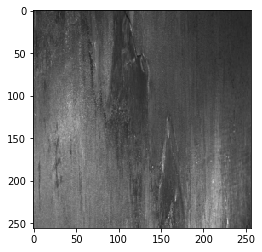

In [0]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

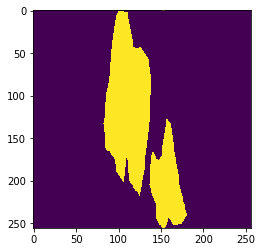

In [0]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

# Models

##DeeplabV3+

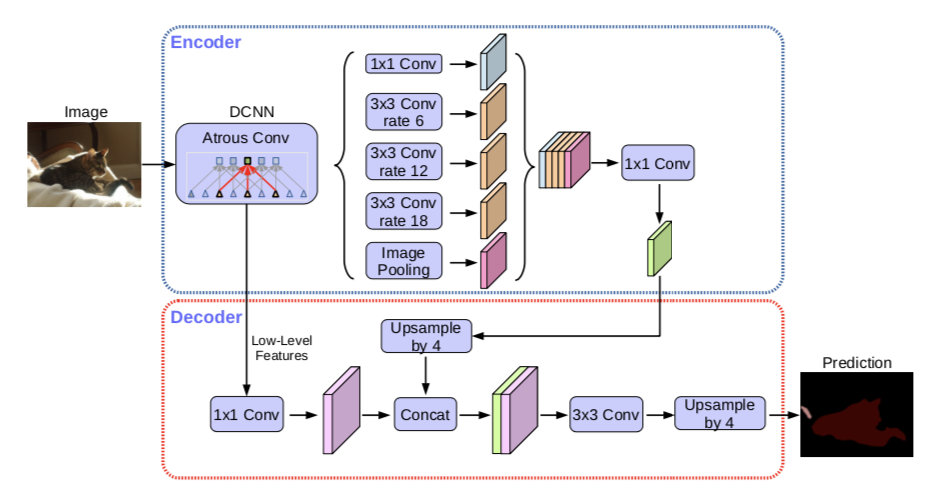

###backbone:  (resnet101)

In [0]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, output_stride, BatchNorm, pretrained=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        blocks = [1, 2, 4]
        if output_stride == 16:
            strides = [1, 2, 2, 1]
            dilations = [1, 1, 1, 2]
        elif output_stride == 8:
            strides = [1, 2, 1, 1]
            dilations = [1, 1, 2, 4]
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], dilation=dilations[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        self._init_weight()

        if pretrained:
            self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample, BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

def ResNet101(output_stride, BatchNorm, pretrained=True):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], output_stride, BatchNorm, pretrained=pretrained)
    return model

def build_backbone(backbone, output_stride, BatchNorm):
    return ResNet101(output_stride, BatchNorm)

###ASPP Module:

In [0]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
def build_aspp(backbone, output_stride, BatchNorm):
    return ASPP(backbone, output_stride, BatchNorm)

###Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm):
        super(Decoder, self).__init__()
        if backbone == 'resnet' or backbone == 'drn':
            low_level_inplanes = 256
        elif backbone == 'xception':
            low_level_inplanes = 128
        elif backbone == 'mobilenet':
            low_level_inplanes = 24
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def build_decoder(num_classes, backbone, BatchNorm):
    return Decoder(num_classes, backbone, BatchNorm)

###deeplab

In [0]:
class DeepLab(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=n_classes,
                 sync_bn=True, freeze_bn=False):
        super(DeepLab, self).__init__()
        if backbone == 'drn':
            output_stride = 8

        BatchNorm = nn.BatchNorm2d

        self.backbone = build_backbone(backbone, output_stride, BatchNorm)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder(num_classes, backbone, BatchNorm)

        if freeze_bn:
            self.freeze_bn()

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, SynchronizedBatchNorm2d):
                m.eval()
            elif isinstance(m, nn.BatchNorm2d):
                m.eval()

# Train Preparation

##loss

In [0]:
class SegmentationLosses(object):
    def __init__(self, weight=None, size_average=True, batch_average=True, ignore_index=255, cuda=False):
        self.ignore_index = ignore_index
        self.weight = weight
        self.size_average = size_average
        self.batch_average = batch_average
        self.cuda = cuda

    def build_loss(self):
        return self.CrossEntropyLoss

    def CrossEntropyLoss(self, logit, target):
        n, c, h, w = logit.size()
        criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index,
                                        reduction='mean')
        if self.cuda:
            criterion = criterion.cuda()

        loss = criterion(logit, target.long())

        if self.batch_average:
            loss /= n

        return loss

## Init for training

In [0]:
last_result = 0
starting_epoch = 0
total_it = 0

model = DeepLab().cuda()
summary(model, (3, 256, 256))
optimizer = torch.optim.SGD(
    model.parameters(), weight_decay=weight_decay, lr = lr, momentum=momentum
)
if reload_last_model and os.path.exists(model_save_path):
  print("Loading model from {}".format(model_save_path))
  state = torch.load(model_save_path)
  last_result = state.get("last_best", 0)
  starting_epoch = state.get("epoch", 0)
  model.load_state_dict(state.get("model_state_dict"))
  if "optimizer_state_dict" in state:
    optimizer.load_state_dict(state.get("optimizer_state_dict"))
  
  if "total_iterations" in state:
    total_it = state.get("total_iterations")
else:
  print("Not load model, train from scrath")
criterion = SegmentationLosses(batch_average=False).build_loss()


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 204MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

## training eval and test functions

Get LR value if we use lr decay

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Eval Matrics:

In [0]:
SMOOTH = 1e-6

def dice_coefficient(x, y):
  """
  :param X: numpy array
  :param y: numpy array
  :return: float, dice coefficient for one x, y pair
  x, y is mask the preidiction values (mask)
  """
  x = x.squeeze()
  y = y.squeeze()
  return 2. * ((x == 1) & (y == 1)).sum(1, 2) / (np.sum(x == 1) + np.sum(y == 1)).sum(1, 2)


def iou_numpy(outputs, labels: np.array):
    outputs = outputs.squeeze()
    if isinstance(outputs, torch.Tensor):
      outputs = outputs.numpy()
    intersection = ((outputs > 0) & (labels > 0)).sum((1, 2))
    union = ((outputs > 0) | (labels > 0)).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded


Inference:

In [0]:
def decode_seg_map_sequence(label_masks):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks


def decode_segmap(label_mask, plot=False):    
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    t = label_mask.copy()
    for c in range(n_classes):
      r[t == c] = label_color[c, 0]
      g[t == c] = label_color[c, 1]
      b[t == c] = label_color[c, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    
    return rgb


def predict(model, data_loader, resize=False, out_mask=True):
    predict = []
    Y = []
    raw = []
    model.eval()
    print("Predicting...")
    total = 0
    losses = []
    print_out = False
    torch.set_printoptions(profile="full")
    with tqdm_notebook(total=len(data_loader.dataset), leave=leave_progress_bar) as pbar:
      for data, y in data_loader:
        with torch.no_grad():
          o = model(data.cuda())  
        o = o.cpu().detach()
        loss = criterion(o, y.squeeze(1))
        losses.append(loss)
        pred = o.numpy()
        pred = np.argmax(pred, axis=1)
        
        if print_out:
          print(pred)
          print_out = False

        predict.append(pred.squeeze(0))
        raw.append(data)
        Y.append(y)

        pbar.update(1)
    predict_loss = np.average(losses)
    print(f"Predict Loss = {predict_loss}")
    return predict, Y, raw, predict_loss


Eval Data:

In [0]:
def eval_data_set(model, data_loader, matrics):
  corr = []
  predictions, Y, raw, loss = predict(model, data_loader)
  for i, mask in enumerate(predictions):
    corr.append(matrics(mask, Y[i].numpy()))
  return np.mean(corr), predictions, Y, raw, loss

Tensorbaord Functions

In [0]:
if clear_tensor_board_history:
  shutil.rmtree("/content/runs", ignore_errors=True)
  os.mkdir("/content/runs")

summary_writter = SummaryWriter() # in ./run by default
#summary_writter.add_graph(model)
def write_image_to_tb(
    predictions, 
    raw_truth, 
    raw, 
    epoch,
    category="eval", 
    update_frequency=10
):
  images_to_add_raw = []
  images_to_add_predict = []
  images_to_add_y = []
  print("total predictions {}".format(len(predictions)))
  for i, prediction in enumerate(predictions):
      if i // update_frequency == 0:
        images_to_add_raw.append(raw[i].squeeze(0))
        prediction = decode_segmap(prediction, plot=False)
        images_to_add_predict.append(torch.from_numpy(prediction).permute(2,0,1))
        truth = raw_truth[i].squeeze().numpy()
        truth = decode_segmap(truth, plot=False)
        images_to_add_y.append(torch.from_numpy(truth).permute(2,0,1))
  #pdb.set_trace()
  summary_writter.add_image(
    f'{epoch}_{category}_raw_img', 
    torchvision.utils.make_grid(images_to_add_raw, nrow=100), 
    epoch
  )
  summary_writter.add_image(
    f'{epoch}_{category}_prediction', 
    torchvision.utils.make_grid(images_to_add_predict, nrow=100, range=(0, 255)), 
    epoch
  )
  summary_writter.add_image(
      f'{epoch}_{category}_ground_truth', 
      torchvision.utils.make_grid(images_to_add_y, nrow=100, range=(0, 255)), 
      epoch
  )
  summary_writter.flush()

Launch Tensorbaord:

In [0]:
%load_ext tensorboard
%tensorboard --logdir=runs

# Train and eval

In [0]:
if inference_mode: 
  total_epochs = 0

total_it = 0
current_it = 1
for epoch in range(starting_epoch, total_epochs):
  total_loss = 0.0
  print(f"Epoch: {epoch}")
  model.train()
  with tqdm_notebook(total=len(train_loader.dataset), leave=leave_progress_bar) as pbar:   
    for it, (data, target) in enumerate(train_loader):
      data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)

      loss = criterion(output, target.squeeze(1))
      loss.backward()
      optimizer.step()
      #pdb.set_trace()
      data_len = len(data)
      pbar.update(len(data))
      pbar.set_postfix(epoch=epoch, loss=loss.item())
      total_it += data_len
      #total_loss += loss.item()
      summary_writter.add_scalar("Loss/train", loss.item(), total_it)
      summary_writter.add_scalar("LR/train", get_lr(optimizer), total_it)
      summary_writter.flush()

  corr, predictions, raw_truth, raw, loss = eval_data_set(
    model, eval_loader, iou_numpy
  )
  write_image_to_tb(predictions, raw_truth, raw, epoch, "eval")
  print("Result = {}".format(corr))
  print("Best = {}".format(last_result))
  summary_writter.add_scalar("IOU/eval", corr, total_it)
  if corr > last_result:
    print("Saving Model...")
    to_save = {
        "epoch": epoch+1 ,
        "total_iterations": total_it,
        "last_best": last_result,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(to_save, model_save_path)
    last_result = corr
  summary_writter.flush()

#Test on Test Set

In [29]:
corr, predictions, raw_truth, raw, loss = eval_data_set(model, test_loader, iou_numpy)
print("Test set IOU = {}".format(corr))
write_image_to_tb(predictions, raw_truth, raw, 1, "test", update_frequency=1)

Predicting...


Predict Loss = 0.14316138625144958
Test set IOU = 0.8736614216549294
total predictions 710


In [0]:
import random
i = random.sample(range(len(test_data)), 3)[0]

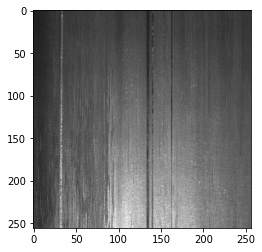

In [67]:
plt.imshow(np.squeeze(test_data[i][0].permute(1, 2, 0)))

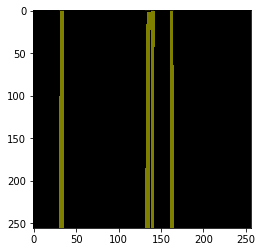

In [68]:
plt.imshow(decode_segmap(np.squeeze(test_data[i][1].permute(1, 2, 0).numpy())))

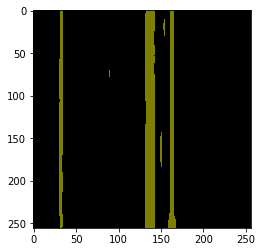

In [69]:
plt.imshow(decode_segmap(predictions[i]))